In [ ]:
#################################
# model train
#################################

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn import metrics
from sklearn.preprocessing import Normalizer
import sklearn
import json
import random
import sklearn.ensemble
from scipy import stats

from FUNCs import plot_mds

class Data(object): 
    def __init__(self):
        pass
    
Data.X = Data()
Data.X.train = pd.read_csv('./Data/Sets/train_GSE36961.csv', index_col=0)
Data.X.test = pd.read_csv('./Data/Sets/test_rna_seq_data.csv', index_col=0)
Data.X.test_strange = pd.read_csv('./Data/Sets/test_GSE1145_extension_target.csv', index_col=0)
Data.y = Data()
Data.y.train = list(pd.read_csv('./Data/Sets/train_GSE36961_target.csv').iloc[:,1])
Data.y.test = list(pd.read_csv('./Data/Sets/test_rna_seq_target.csv').iloc[:,1])
Data.y.test_strange = list(pd.read_csv('./Data/Sets/test_GSE1145_extension_target.csv').iloc[:,1])

best_features = list(pd.read_csv('./result/best_o_best_feature_plus.csv').iloc[:,0])
best_features = list(pd.read_csv('./result/best_features.csv').iloc[:,0])
best_features = ['TUBA3E', 'MYH6', 'ZFP36']

from sklearn.utils import resample

class Bootstrap:
    
    '''Bootstrap cross validator.'''
    
    def __init__(self,n_bootstraps=5):
        self.nb = n_bootstraps
    
    def split(self, X, y=None):
        '''"""Generate indices to split data into training and test set.'''
        iX = np.mgrid[0:X.shape[0]]
        for i in range(self.nb):
            train = resample(iX)
            test = [item for item in iX if item not in train]
            yield (train,test)

def model_test(model=None, n_iter=None, X=None, y=None):
    roc_auc_pull = dict()

    Boot = Bootstrap(n_bootstraps=n_iter)

    roc_auc = list()

    for train, test in Boot.split(X):
        model = model.fit(X.iloc[train,:], y[train])
        roc_auc.append(metrics.roc_auc_score(y_score=model.predict(X.iloc[test,:]), y_true=y[test]))
    
    return(roc_auc)

In [2]:
best_features = ['AP3M2', 'ARPC3', 'C19ORF59', 'C1R', 'C5ORF4', 'CCND2', 'CD209', 'CDC42EP4', 'CEBPD', 'CHST7', 'DDOST', 'DNAJC21', 'EBI2', 'FCGR1B', 'FCN3', 'FKBP5', 'HEG1', 'HS.177532', 'IL18R1', 'IL1RL1', 'LOC654264', 'MAP3K6', 'MAP3K8', 'MLLT11', 'MVP', 'NKD2', 'PLEK', 'SCN2B', 'SEC14L1', 'SEMA4B', 'SLC12A9', 'SLC15A3', 'SMAP2', 'SRGN', 'STAT3', 'TKT', 'TSPAN32', 'TUBA3C', 'TUBA3D']

In [36]:
best_features = ['ZFP36',
 'FCN3',
 'MT1M',
 'RASD1',
 'C1R',
 'CDC42EP4',
 'PRKCD',
 'CEBPD',
 'MYH6',
 'TUBA3E',
 'YPEL2',
 'IRX6']

best_features = ['ACE2', 'APOA1', 'ATP1A2', 'C21ORF7', 'CA3', 'CENPA', 'CLIC6', 'EIF1AY',
       'FRZB', 'HS.576694', 'HSPA2', 'IER3', 'LOC100008589', 'MLLT11', 'MXRA5',
       'NPPA', 'NPPB', 'PROS1', 'RASD1', 'RASL11B', 'S100A9', 'SERPINA3',
       'SFRP1', 'SMOC2', 'THBS4', 'TPM3']

In [37]:
X = Data.X.train.transpose().filter(best_features, axis=1)
X_test_out = Data.X.test.transpose().filter(best_features, axis=1)

y = np.array(Data.y.train)
y_test_out = np.array(Data.y.test)

In [38]:
X = X.filter(list(set(X.columns).intersection(X_test_out.columns)), axis=1)
X = X.reindex(sorted(X.columns), axis=1)
X_test_out = X_test_out.reindex(sorted(X_test_out.columns), axis=1)

In [148]:
# Вариант Вадима

#X = pd.DataFrame(sklearn.preprocessing.scale(Data.X.train.transpose(), axis=1), columns = Data.X.train.transpose().columns).filter(best_features, axis=1)
#X_test_out = pd.DataFrame(sklearn.preprocessing.scale(Data.X.test.transpose(), axis = 1), columns = Data.X.test.transpose().columns).filter(best_features, axis=1)

#y = Data.y.train
#y_test_out = Data.y.test


In [ ]:
##############
# RF train
##############

In [39]:
norm = Normalizer()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_n = pd.DataFrame(norm.fit_transform(X_train), columns=X_train.columns)
X_test_n = pd.DataFrame(norm.fit_transform(X_test), columns=X_test.columns)

In [40]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [41]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_n, y_train)
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 34, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 7, 'bootstrap': False}


(array([ 1.,  0.,  1.,  3.,  3.,  3., 11.,  7., 10., 11.]),
 array([0.89285714, 0.90357143, 0.91428571, 0.925     , 0.93571429,
        0.94642857, 0.95714286, 0.96785714, 0.97857143, 0.98928571,
        1.        ]),
 <a list of 10 Patch objects>)

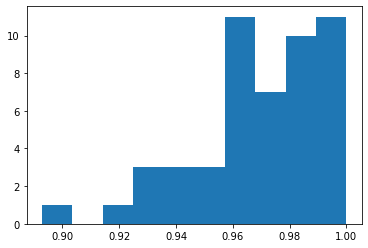

In [12]:
plt.hist(model_test(RandomForestClassifier(**rf_random.best_params_), 50, X, y))

In [42]:
best_rf_model = RandomForestClassifier(**rf_random.best_params_)

In [ ]:
##############
# LogReg train
##############

In [43]:
norm = Normalizer()
Scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_n = pd.DataFrame(Scaler.fit_transform(norm.fit_transform(X_train)), columns=X_train.columns)
X_test_n = pd.DataFrame(Scaler.transform(norm.fit_transform(X_test)), columns=X_test.columns)

In [50]:
# Create param grid.

param_grid = {'penalty' : ['l2'],
              'C' : np.logspace(-4, 4, 30),
              'solver' : ['liblinear']}

In [51]:
# Create grid search object

clf = RandomizedSearchCV(LogisticRegression(), param_distributions = param_grid, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train_n, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [52]:
print(best_clf.best_params_)
print(best_clf.best_score_)

{'solver': 'liblinear', 'penalty': 'l2', 'C': 2807.2162039411755}
1.0


In [53]:
best_LogReg_model = LogisticRegression(**best_clf.best_params_)

In [ ]:
##############
# XGBoost train
##############

In [15]:
import xgboost as xgb
from xgboost import XGBClassifier

In [16]:
norm = Normalizer()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_n = pd.DataFrame(norm.fit_transform(X_train), columns=X_train.columns)
X_test_n = pd.DataFrame(norm.fit_transform(X_test), columns=X_test.columns)

In [17]:
param_dist = {'objective':'binary:logistic', 
              'n_estimators':70, 
              'max_depth': 10, 
              'learning_rate': 0.1, 
              'subsample': 0.5}

In [18]:
model = XGBClassifier(**param_dist)
# define the datasets to evaluate each iteration
evalset = [(X_train_n, y_train), (X_test_n, y_test)]
# fit the model
model.fit(X_train_n, y_train, eval_metric='auc', eval_set=evalset)
# evaluate performance
yhat = model.predict(X_test_n)
score = metrics.roc_auc_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()

[0]	validation_0-auc:0.95659	validation_1-auc:0.86389
[1]	validation_0-auc:0.97984	validation_1-auc:0.91667
[2]	validation_0-auc:0.99729	validation_1-auc:0.91667
[3]	validation_0-auc:0.99884	validation_1-auc:0.92500
[4]	validation_0-auc:0.99845	validation_1-auc:0.92500
[5]	validation_0-auc:0.99845	validation_1-auc:0.91944
[6]	validation_0-auc:0.99806	validation_1-auc:0.91944
[7]	validation_0-auc:0.99806	validation_1-auc:0.91944
[8]	validation_0-auc:0.99845	validation_1-auc:0.91667
[9]	validation_0-auc:0.99923	validation_1-auc:0.91667
[10]	validation_0-auc:0.99923	validation_1-auc:0.91667
[11]	validation_0-auc:0.99923	validation_1-auc:0.91667
[12]	validation_0-auc:0.99923	validation_1-auc:0.91667
[13]	validation_0-auc:0.99923	validation_1-auc:0.91667
[14]	validation_0-auc:0.99923	validation_1-auc:0.91667
[15]	validation_0-auc:0.99884	validation_1-auc:0.91111
[16]	validation_0-auc:0.99923	validation_1-auc:0.90278
[17]	validation_0-auc:0.99961	validation_1-auc:0.90278
[18]	validation_0-au

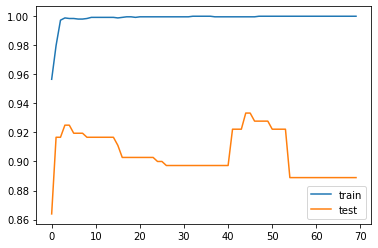

In [19]:
# plot learning curves
plt.plot(results['validation_0']['auc'], label='train')
plt.plot(results['validation_1']['auc'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

In [20]:
best_xgb = XGBClassifier(**param_dist)

In [ ]:
##############
# Пробуем Stacking
##############

In [54]:
estimators = [
    ('rf', make_pipeline(Normalizer(),
                         best_rf_model)),
    ('logreg', make_pipeline(Normalizer(),
                             StandardScaler(),
                             best_LogReg_model)),
#    ('xgb', make_pipeline(Normalizer(),
#                          best_xgb))
    ]
clf = StackingClassifier(estimators=estimators, 
                         final_estimator=LogisticRegression(penalty='l2', C=1), 
                         passthrough = False, stack_method='predict_proba')

In [55]:
best_LogReg_model = LogisticRegression()

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clfStack = clf.fit(X_train, y_train)

print("train:", metrics.roc_auc_score(y_score=clfStack.predict(X_train), 
                                      y_true=y_train))
print('test_in:', metrics.roc_auc_score(y_score=clfStack.predict(X_test), 
                                           y_true=y_test))
print("test_out:", metrics.roc_auc_score(y_score=clfStack.predict(X_test_out), 
                                     y_true=y_test_out))
#print("test_out_ext:", metrics.roc_auc_score(y_score=clfStack.predict(X_test_out_extension), 
#                                     y_true=y_test_out_extension))
print('Log_reg only:')
clf = make_pipeline(Normalizer(), 
                    StandardScaler(), 
                    best_LogReg_model)

print("train:", metrics.roc_auc_score(y_score=clf.fit(X_train, y_train).predict(X_train), 
                                      y_true=y_train))
print('test_in:', metrics.roc_auc_score(y_score=clf.fit(X_train, y_train).predict(X_test), 
                                           y_true=y_test))
print("test_out:", metrics.roc_auc_score(y_score = clf.fit(X_train, y_train).predict(X_test_out), 
                                     y_true=y_test_out))

train: 1.0
test_in: 0.9444444444444444
test_out: 0.5
Log_reg only:
train: 1.0
test_in: 0.9444444444444444
test_out: 0.5


In [323]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

roc_auc_pull_test = list()
roc_auc_pull_train = list()

for i in np.logspace(-4, 4, 30):
    
    clf = make_pipeline(Normalizer(), 
                        StandardScaler(), 
                        LogisticRegression(penalty='l2', C=i))
    clf.fit(X_train, y_train)
    roc_auc_pull_test.append(metrics.roc_auc_score(y_score=clf.predict(X_test), y_true=y_test))
    roc_auc_pull_train.append(metrics.roc_auc_score(y_score=clf.predict(X_train), y_true=y_train))

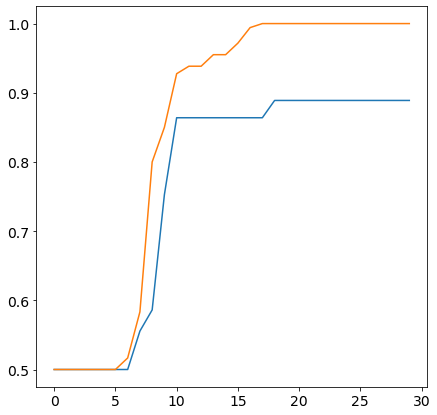

In [337]:
plt.plot(roc_auc_pull_test)
plt.plot(roc_auc_pull_train)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.logspace(-4, 4, 30)[11]
clf = make_pipeline(Normalizer(), 
                    StandardScaler(), 
                    LogisticRegression(penalty='l2', C=0.1))
clf.fit(X_train, y_train)

print("train:", metrics.roc_auc_score(y_score=clf.predict(X_train), 
                                      y_true=y_train))
print('test_in:', metrics.roc_auc_score(y_score=clf.predict(X_test), 
                                           y_true=y_test))
print("test_out:", metrics.roc_auc_score(y_score=clf.predict(X_test_out), 
                                     y_true=y_test_out))

train: 1.0
test_in: 0.9444444444444444
test_out: 0.5


In [428]:
def Boot_test(model, X, y, n_iter):
    roc_auc_pull = list()
    
    for i in range(n_iter):
        
        iX = np.mgrid[0:X.shape[0]]
        ind = resample(iX)
        
        _X = X.iloc[ind,:]
        _y = y[ind]
        
        if sum(_y) == len(_y) or sum(_y == 0) == len(y):
            continue
        
        roc_auc_pull.append(metrics.roc_auc_score(y_score=model.predict(_X), 
                                     y_true=_y))
        
    return(roc_auc_pull)

In [435]:
result = Boot_test(clf, X_test_out, y_test_out, 1000)

95% CI: [0.71425265 1.        ]


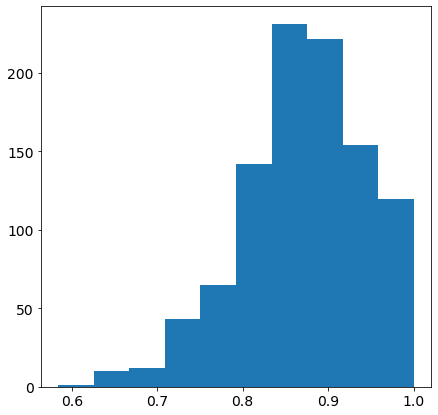

In [436]:
plt.hist(result)
print("95% CI:", np.percentile(result, [2.5, 97.5]))

In [12]:
#################################
# interpretaion
#################################

In [358]:
clfStack = clf

In [343]:
import shap

In [359]:
X_train_summary = shap.kmeans(X_train, 10)
ex = shap.KernelExplainer(clfStack.predict, X_train_summary)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


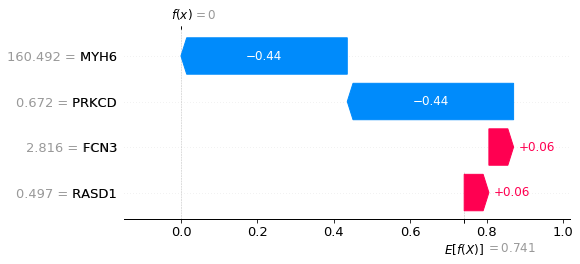

In [360]:
shap.initjs()
shap_values = ex.shap_values(X_test_out.iloc[9,:])
shap.plots.waterfall.waterfall_plot(ex.expected_value, shap_values, X_test_out.iloc[9,:])

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


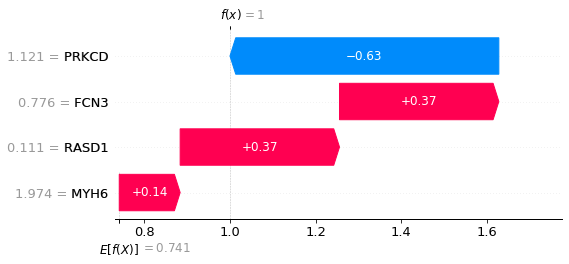

In [361]:
shap.initjs()
shap_values = ex.shap_values(X_test_out.iloc[13,:])
shap.plots.waterfall.waterfall_plot(ex.expected_value, shap_values, X_test_out.iloc[13,:])

In [362]:
shap.initjs()
shap_values = ex.shap_values(X_test_out)
shap.force_plot(ex.expected_value, shap_values, X_test_out)

  0%|          | 0/37 [00:00<?, ?it/s]

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

In [348]:
def shap_plot(X, y, shap_values):

    spdf = pd.DataFrame(shap_values[np.array(y) != 1,:], columns=X.columns)

    spdf_ctrl = pd.DataFrame(spdf.sum(axis=0), columns=['CTRL'])

    spdf_hcn = pd.DataFrame(shap_values[np.array(y) == 1,:], columns=X.columns)
    spdf_hcn = pd.DataFrame(spdf_hcn.sum(axis=0), columns=['HCM'])

    spdf = pd.concat([spdf_hcn, spdf_ctrl], axis=1)

    x = spdf['CTRL']
    y = spdf['HCM']

    plt.figure(figsize=(13,13))
    plt.scatter(x, y)
    plt.axvline(0)
    plt.axhline(0)
    plt.xlabel('CTRL SHAPE value')
    plt.ylabel('HCM SHAPE value')
    for i, txt in enumerate(spdf.index):
        plt.annotate(txt, (x[i], y[i]))

    return(spdf)
    #plt.savefig('./shape_by_gene.png', dpi = 300)

  0%|          | 0/37 [00:00<?, ?it/s]

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

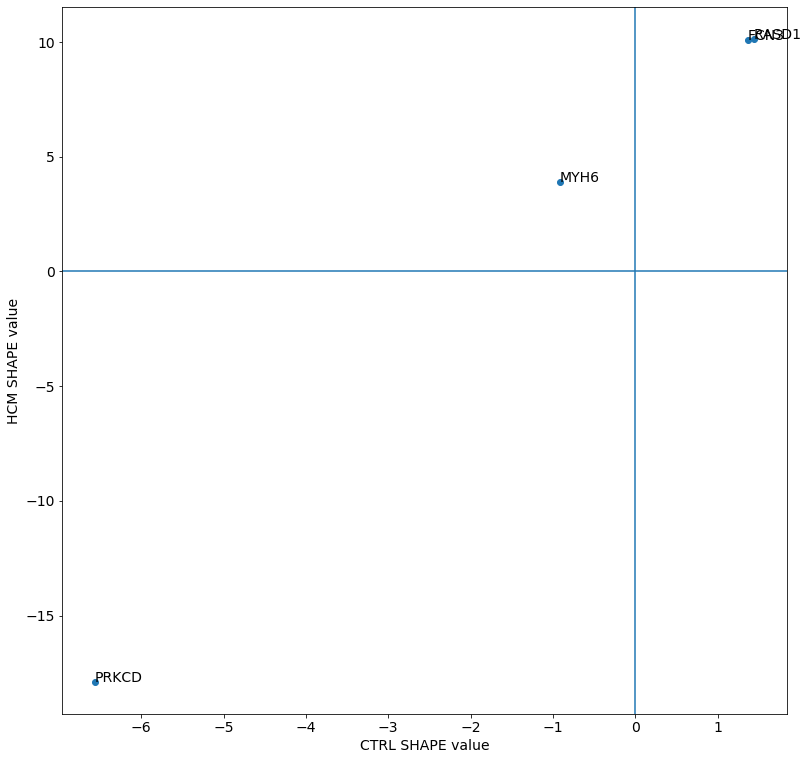

In [349]:
shap_values = ex.shap_values(X_test_out)
spdf = shap_plot(X_test_out, y_test_out, shap_values)
spdf.to_csv('../best_genes_SHAPE_distance.csv')

In [21]:
#################################
# reactome 
#################################

In [37]:
print(*best_features, sep=', ')

FCN3, MT1X, PROS1, MYH6, CDC42EP4, ZFP36, PRKCD, LYVE1, CEBPD, MT1M, RASD1, S1PR3


In [43]:
import json

In [44]:
f = open('../Data/ReactomePathways.gmt', 'r')

Reactome_path = dict()
for i in f:
    line = i.rstrip('\n').split('\t')
    Reactome_path[line[1]] = {'name': line[0], 
                           'genes': line[2:]}

In [45]:
def grep_path_ID(x, gene):
    if gene in Reactome_path[x]['genes']:
        return x

gene_to_path = dict()
for gene in best_features:
    _paths = np.array(list(map(lambda x: grep_path_ID(x, gene=gene), Reactome_path.keys())))
    
    _paths = list(_paths[_paths != None])
    
    gene_to_path[gene] = dict()
    
    if len(_paths) != 0:
    
        for path in _paths:
            if len(Reactome_path[path]['genes']) < 500:
                gene_to_path[gene][path] = Reactome_path[path]['genes']

In [26]:
with open('../Data/best_gene_to_path.json', 'w') as outfile:
    json.dump(gene_to_path, outfile)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd3ce19910>,
      dtype=object)

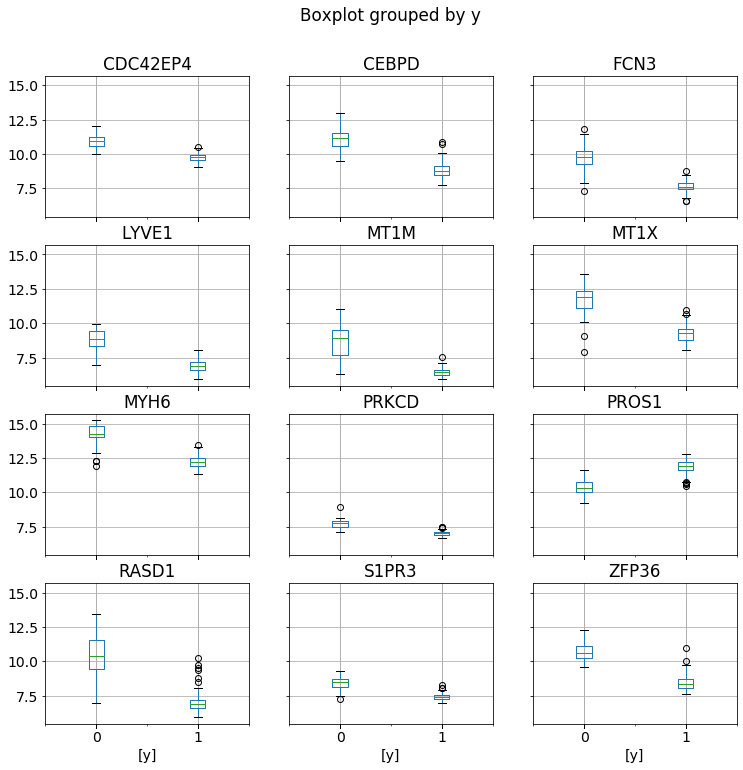

In [40]:
data = X
data['y'] = y
data.head()
data.boxplot(by='y', figsize=(12,12))

In [262]:
ATG = Reactome_path['R-HSA-9612973']['genes']

ATG = Reactome_path['R-HSA-5205647']['genes']

ATG = ['LC3II', 'BECN1', 'BCL2', 'BAX', 'CASP3']

In [263]:
X = pd.read_csv('./X_train.csv', index_col=0).transpose()

In [240]:
colnames = X.columns
normalizer = Normalizer()
data = pd.DataFrame(normalizer.fit_transform(np.log(X)), columns=colnames)

In [241]:
data = pd.DataFrame(data.transpose())

In [242]:
data.to_csv('./for_Reactome_GSEA.csv')

In [247]:
np.array(data.columns)[np.array(y)==0]

array([106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144])

In [264]:
X_ATG = np.log(X.loc[:,list(map(lambda x: x in ATG, X.columns))])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd0bdfc210>,
      dtype=object)

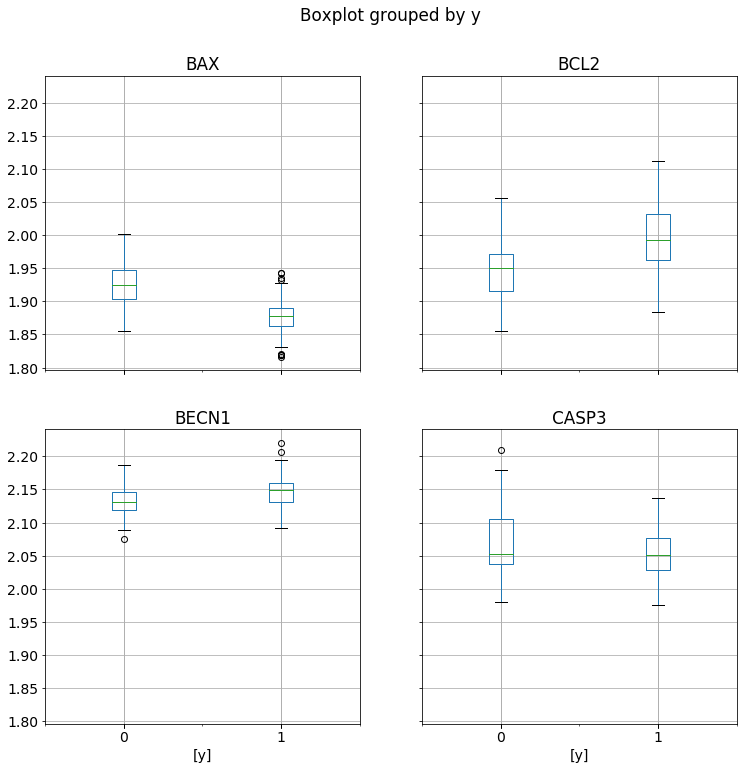

In [265]:
X_ATG['y'] = y
X_ATG.boxplot(by='y', figsize=(12,12)) 

In [270]:
pvalues = list()
for i in range(0,X_ATG.shape[1]-1):
    pvalue = stats.wilcoxon(X_ATG.iloc[:,i][np.array(y)==1][0:39], X_ATG.iloc[:,i][np.array(y)==0]).pvalue
    pvalues.append(pvalue)
    
pvalues_adj = multi.multipletests(pvalues, method='fdr_bh')[1]

In [198]:
import statsmodels.stats.multitest as multi

In [273]:
list(zip(X_ATG.columns, pvalues_adj))

[('BECN1', 0.022691528801486407),
 ('BCL2', 5.131492843088875e-06),
 ('BAX', 3.123793014241283e-06),
 ('CASP3', 0.4595337043249743)]

(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([3.12379301e-06, 4.59561818e-02, 9.19092399e-02, 1.37862298e-01,
        1.83815356e-01, 2.29768414e-01, 2.75721472e-01, 3.21674530e-01,
        3.67627588e-01, 4.13580646e-01, 4.59533704e-01]),
 <a list of 10 Patch objects>)

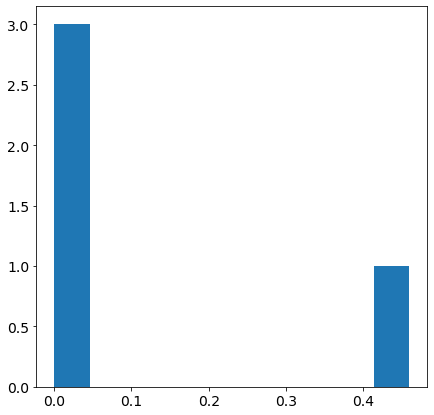

In [272]:
plt.hist(pvalues_adj)

In [211]:
np.array(X_ATG.columns)[np.array(pvalues_adj) < 0.05]

array(['APOB', 'APOA1', 'GSN', 'AKR1C4', 'GNB1', 'AGRN', 'SDC2', 'MYO1C',
       'OR51E1', 'EPB41L1', 'AKR1B10', 'RDH10', 'PDE6A', 'MYH9', 'KCNMA1',
       'RDH5', 'GUCA1C', 'SPTAN1', 'MSN', 'AKR1C3', 'METAP2', 'CTBP2',
       'GPC1', 'XIRP2', 'PDE6B', 'SPTBN1', 'LRP8', 'EPB41L3', 'DHRS3',
       'FAM65B', 'APOE', 'LDLR', 'GRK4', 'TMIE', 'GUCA1B', 'RETSAT',
       'NMT1', 'KCNMB1', 'CAPZB', 'GPIHBP1', 'NAPEPLD', 'MYO7A', 'DNAJC5',
       'CABP1', 'PRKCQ', 'RBP1', 'GNAT1', 'APOM'], dtype=object)

In [115]:
np.array(X_ATG.columns)[np.array(pvalues) < 0.05]

array(['PRKAA2', 'PCNT', 'PARK7', 'ATG7', 'GABARAP', 'MAP1LC3A',
       'CSNK2A1', 'WDR45', 'VPS37C', 'RRAGB', 'DYNLL1', 'VPS37A',
       'PIK3R4', 'MFN2', 'GABARAPL1', 'CHMP4B', 'ATG4C', 'TOMM40',
       'MTMR3', 'HSF1', 'DYNC1LI2', 'CHMP2A', 'BECN1', 'ATG4D', 'RNASE1',
       'RRAGD', 'FUNDC1', 'HBB', 'DYNC1H1', 'ATG4B', 'UBAP1', 'ULK1',
       'RB1CC1', 'IFT88', 'TSC1', 'ATG5', 'RHEB', 'CSNK2A2', 'GABARAPL2',
       'PGAM5', 'VDAC1', 'WIPI1', 'CHMP7', 'VPS37B', 'MTMR14', 'VPS37D',
       'UBC', 'PRKAG1', 'MAP1LC3B', 'EPAS1', 'DYNC1LI1', 'UBB', 'ATM',
       'PRKAB2', 'ATG10', 'VCP'], dtype=object)